In [6]:
import math
import os
import re

import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [7]:
DATA_DIR = '../../data'

In [3]:
#f1d = open(os.path.join(DATA_DIR, 'electricityConsumption.txt'), 'r')
#data = []
#cid = 250
#for line in f1d:
#    if line.startswith('"";"'):
#        continue
#    cols = [float(re.sub(',', '.', x)) 
#            for x in line.strip().split(';')[1:]]
#    data.append(cols[cid])
#f1d.close()

In [16]:
N_ENTRIES = 1000
#plt.plot(range(N_ENTRIES), data[0:N_ENTRIES])
#plt.ylabel('Electricity Consumption')
#plt.xlabel('time (15 min intervals)');

In [15]:
#np.save(
#    os.path.join(DATA_DIR, 'electicityConsumption.npy'), np.array(data))

In [8]:
data = np.load(os.path.join(DATA_DIR, 'electicityConsumption.npy'))
data = data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
data = scaler.fit_transform(data)

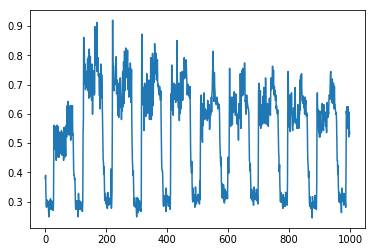

In [17]:
plt.plot(data[:N_ENTRIES]);

In [50]:
N_TIMESTEPS = 20

In [51]:
X = np.zeros((data.shape[0], N_TIMESTEPS))
Y = np.zeros((data.shape[0], 1))
for i in range(len(data) - N_TIMESTEPS - 1):
    X[i] = data[i:i + N_TIMESTEPS].T
    Y[i] = data[i + N_TIMESTEPS + 1]
# Reshpae X to 3 dims (samples, timesteps, features)
X = np.expand_dims(X, axis=2)

In [52]:
sp = int(0.7 * len(data))
X_train, X_test, Y_train, Y_test = X[0:sp], X[sp:], Y[0:sp], Y[sp:]
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(98179, 20, 1) (42077, 20, 1) (98179, 1) (42077, 1)


In [53]:
HIDDEN = 10
BATCH = 96 # = 24 hours of 15-min intervals
EPOCHS = 30

In [54]:
# Stateless model
stateless_mod = Sequential()
stateless_mod.add(LSTM(
    HIDDEN, input_shape=(N_TIMESTEPS, 1), return_sequences=False))
stateless_mod.add(Dense(1))

In [55]:
# Stateful
stateful_mod = Sequential()
stateful_mod.add(LSTM(HIDDEN, 
                      stateful=True, 
                      batch_input_shape=(BATCH, N_TIMESTEPS, 1), 
                      return_sequences=False))
stateful_mod.add(Dense(1))

In [56]:
stateless_mod.compile(loss='mse', optimizer='adam', metrics=['mse'])
stateful_mod.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [57]:
stateless_history = stateless_mod.fit(X_train, 
                                      Y_train, 
                                      epochs=EPOCHS, 
                                      batch_size=BATCH, 
                                      validation_data=(X_test, Y_test), 
                                      shuffle=False)

Train on 98179 samples, validate on 42077 samples
Epoch 1/30
98179/98179 [==============================] - 20s 203us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 2/30
98179/98179 [==============================] - 19s 195us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 3/30
98179/98179 [==============================] - 20s 200us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/30
98179/98179 [==============================] - 19s 196us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/30
98179/98179 [==============================] - 19s 198us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/30
98179/98179 [==============================] - 19s 191us/step - loss: 0.0042 - mean_squared_er

In [58]:
def plot_performance(history):
    plt.plot(history.history['loss'], 'k-', label='train')
    plt.plot(history.history['val_loss'], 'r-', label='valid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend();

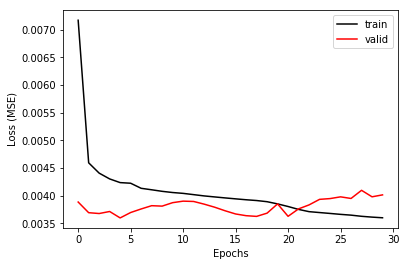

In [59]:
plot_performance(stateless_history)

In [60]:
# For stateful, training and test data must be mult of BATCH
train_size = (X_train.shape[0] // BATCH) * BATCH
test_size  = (X_test.shape[0]  // BATCH) * BATCH
X_train, Y_train = X_train[0:train_size], Y_train[0:train_size]
X_test,  Y_test  = X_test[0:test_size],   Y_test[0:test_size]
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(98112, 20, 1) (42048, 20, 1) (98112, 1) (42048, 1)


In [61]:
class History:
    def __init__(self):
        self.history = {'loss': [], 'val_loss': []}
    
    def update(self, history):
        self.history['loss'] += history.history['loss']
        self.history['val_loss'] += history.history['val_loss']

In [62]:
stateful_history = History()

for i in range(EPOCHS):
    print(f'Epoch {i + 1}/{EPOCHS}')
    history = stateful_mod.fit(X_train, 
                               Y_train, 
                               batch_size=BATCH, 
                               epochs=1, 
                               validation_data=(X_test, Y_test), 
                               shuffle=False)
    stateful_history.update(history)
    stateful_mod.reset_states()

Epoch 1/30
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 12s 123us/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 2/30
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 11s 115us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 3/30
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 12s 119us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/30
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 11s 117us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 5/30
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [

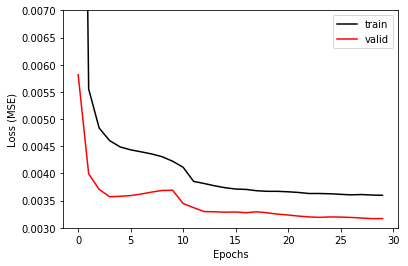

In [66]:
plot_performance(stateful_history)
plt.ylim([0.003, 0.007]);